In [3]:
import data_handler
import dilated_model as DM
import trainer as T
import numpy as np
import torch as th
from torch.autograd import Variable
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)
from os.path import basename, splitext

th.multiprocessing.set_sharing_strategy('file_system')
name = splitext(basename(sys.argv[0]))[0]

transformations = [
    data_handler.Crop(2400),
    data_handler.Threshold(sigma=2.2),
    data_handler.RandomMultiplier(-1),
]

dataset = data_handler.DataSet(
    'data/raw/training2017/REFERENCE.csv', data_handler.load_composed,
    transformations=transformations,
    path='data/raw/training2017/',
    remove_noise=True, tokens='NAO')
train_set, eval_set = dataset.disjunct_split(.9)


net = DM.ResNet(K_blocks=4, 
                N_res_in_block=1, 
                channel=4, use_selu=True)

<bound method ResNet.forward of ResNet (
  (conv_init): Conv1d(1, 4, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (bn_init): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True)
  (nonlin): SELU (
  )
  (net): Sequential (
    (0): ConvModule (
      (residuals): Sequential (
        (0): DilatedBlock (
          (nonlin): SELU (
          )
          (block): Sequential (
            (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True)
            (1): Conv1d(4, 4, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
            (2): SELU (
            )
            (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True)
            (4): Dropout (p = 0.5, inplace)
            (5): Conv1d(4, 4, kernel_size=(17,), stride=(1,), padding=(16,), dilation=(2,), bias=False)
            (6): SELU (
            )
          )
        )
      )
    )
    (1): ConvModule (
      (residuals): Sequential (
        (0): DilatedBlock (
          (nonlin): SELU (
          )


In [5]:
net.cuda()
test_data = Variable(next(iter(train_set))['x'].float())[None].cuda()

In [17]:
%%timeit
res = net.forward_features(test_data)

38.3 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%time
res = net.forward_features(test_data)

CPU times: user 1.65 s, sys: 56.1 ms, total: 1.7 s
Wall time: 48.2 ms


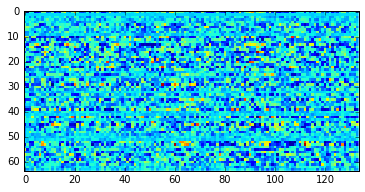

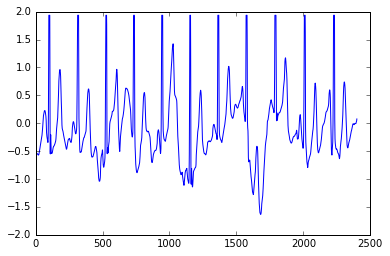

In [16]:
import matplotlib.pyplot as plt

plt.imshow(res.data.numpy()[0], interpolation='None')
plt.show()
plt.plot(test_data.data.numpy()[0, 0])
plt.show()